Building a Memory-Enhanced Email Agent with LangGraph
This tutorial demonstrates how to build an advanced AI agent with three types of memory using LangGraph and LangMem. We'll create an email assistant that can remember important facts, learn from past examples, and improve its behavior based on feedback.

Key Memory Types:
Semantic Memory: Stores facts and knowledge about contacts, preferences, and contexts
Episodic Memory: Remembers specific past interactions and examples
Procedural Memory: Learns and improves behavioral patterns over time
Tutorial Overview: Email Assistant with Memory
In this tutorial, we'll build an email agent that can:

Triage emails: Classify incoming emails as 'ignore', 'notify', or 'respond'
Draft responses: Compose contextually appropriate replies using stored knowledge
Learn from feedback: Improve its performance based on user corrections

In [1]:
import os
from dotenv import load_dotenv
from typing import TypedDict, Literal, Annotated, List
from langgraph.graph import StateGraph, START, END, add_messages
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langchain.prompts import PromptTemplate
from langchain.schema import HumanMessage
from pydantic import BaseModel, Field
from langgraph.store.memory import InMemoryStore  # For storing memories
from langmem import create_manage_memory_tool, create_search_memory_tool # LangMem!

In [2]:
# Load env variables (openAI api key)
load_dotenv()

# init LLM
llm = init_chat_model("openai:gpt-4o-mini")

# Init the meory store (we'll use an in-memory store for simplicity)
store = InMemoryStore(index={"embed": "openai:text-embedding-3-small"})

/Users/kylestanford/Library/CloudStorage/OneDrive-Partners/Documents/GitHub/World_of_Agents/agent_world_venv/lib/python3.12/site-packages/langgraph/store/base/embed.py:95: LangChainBetaWarning: The function `init_embeddings` is in beta. It is actively being worked on, so the API may change.
  return init_embeddings(embed)


In [4]:
# Defining the agent "Brain" State
class State(TypedDict):
    email_input: dict #Incoming email
    messages: Annotated[list, add_messages] #The conversation history
    triage_result: str #the result of the triage (ignore, notify, respond)

In [6]:
# Triage center: Deciding what to do (Episodic Memory)
class Router(BaseModel):
    reasoning: str = Field(description="Step-by-step reasoning behind the classification.")
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'ignore', 'notify', or 'respond'."
    )

llm_router = llm.with_structured_output(Router)

In [8]:
# Enhance triage_email function
def format_few_shot_examples(examples):
    formatted_examples = []
    for eg in examples:
        email = eg.value['email']
        label = eg.value['label']
        formatted_examples.append(
            f"From: {email['author']}\nSubject: {email['subject']}\nBody: {email['email_thread'][:300]}...\n\nClassification: {label}"
        )
    return "\n\n".join(formatted_examples)

In [10]:
def triage_email(state: State, config: dict, store: InMemoryStore) -> dict:
    email = state["email_input"]
    user_id = config["configurable"]["langgraph_user_id"]
    namespace = ("email_assistant", user_id, "examples") #Namespace for episodic memory

    # Retrieve relevant examples from memory
    examples = store.search(namespace, query=str(email))
    formatted_examples = format_few_shot_examples(examples)

    prompt_template = PromptTemplate.from_template("""You are an email triage assistant.  Classify the following email:
    From: {author}
    To: {to}
    Subject: {subject}
    Body: {email_thread}

    Classify as 'ignore', 'notify', or 'respond'.

    Here are some examples of previous classifications:
    {examples}
    """)

    prompt = prompt_template.format(examples=formatted_examples, **email)
    messages = [HumanMessage(content=prompt)]
    result = llm_router.invoke(messages)
    return {"triage_result": result.classification}

In [12]:
# ACTION TIMEEEE
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email"""
    print(f"Sending email to {to} with subject '{subject}'\nContent:\n{content}\n")
    return f"Email sent to {to} with subject '{subject}'"

In [13]:
@tool
def check_calendar_availability(day: str) -> str:
    """Checl calendar availability for a given day"""
    return f"Availabl;e times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

In [14]:
# Create langmem memory tools (using the configured user ID)
manage_memory_tool = create_manage_memory_tool(namespace=("email_assistant", "{langgraph_user_id}", "collection"))
search_memory_tool = create_search_memory_tool(namespace=("email_assistant", "{langgraph_user_id}", "collection"))

tools = [write_email, check_calendar_availability, manage_memory_tool, search_memory_tool]

In [15]:
# Response agent: Putting it all togeteher (with Semantic Memory!)
from langgraph.prebuilt import create_react_agent

def create_agent_prompt(state, config, store):
    messages = state['messages']
    user_id = config["configurable"]["langgraph_user_id"]

    # Get the current response prompt from procedural memory
    system_prompt = store.get(("email_assistant", user_id, "prompts"), "response_prompt").value

    return [{"role": "system", "content": system_prompt}] + messages

# Try using the current api signature
response_agent = create_react_agent(
    tools = tools,
    prompt = create_agent_prompt,
    store=store,
    model=llm
)

In [17]:
# Building the graph, connecting the pieces
workflow = StateGraph(State)

# Update this line to pass the store to the node
workflow.add_node("triage", lambda state, config: triage_email(state, config, store))
workflow.add_node("response_agent", response_agent)

def route_based_on_triage(state):
    if state["triage_result"] == "respond":
        return "response_agent"
    else:
        return END
    
workflow.add_edge(START, "triage")
workflow.add_conditional_edges("triage", route_based_on_triage, {
    "response_agent": "response_agent",
    END: END
})

# compile the graph
agent = workflow.compile(store=store)

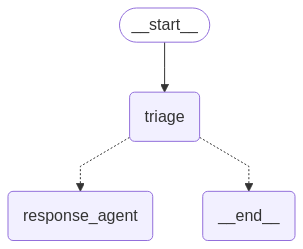

In [18]:
# DISPLAY CURRENT AGENT
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image

display(
    Image(
        agent.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [19]:
# Adding procedural Memory (updating instructions)
initial_triage_prompt = """You are an email triage assistant. Classify the following email:
From: {author}
To: {to}
Subject: {subject}
Body: {email_thread}

Classify as 'ignore', 'notify', or 'respond'.

Here are some examples of previous classifications:
{examples}
"""


In [20]:
initial_response_prompt = """You are a helpful assistant. Use the tools available, including memory tools, to assist the user."""

In [21]:
# Store these prompts in the meory state
store.put(("email_assistant", "test_user", "prompts"), "triage_prompt", initial_triage_prompt)

In [22]:
store.put(("email_assistant", "test_user", "prompts"), "response_prompt", initial_response_prompt)

In [23]:
def triage_email_with_procedural_memory(state: State, config: dict, sotre: InMemoryStore) -> dict:
    email = state["email_input"]
    user_id = config["configurable"]["langgraph_user_id"]

    # retrieve the current triage prompt (procedural memoyr)
    current_prompt_template = store.get(("email_assistant", user_id, "prompts"), "triage_prompt").value

    # Retrieve relevant eamples from memory (episodic memory)
    namespace = ("email_assistant", user_id, "examples")
    examples = store.search(namespace, query=str(email))
    formatted_examples = format_few_shot_examples(examples)

    # Format the prompt
    prompt = PromptTemplate.from_template(current_prompt_template).format(examples=formatted_examples, **email)
    messages = [HumanMessage(content=prompt)]
    result = llm_router.invoke(messages)
    return {"triage_result": result.classification}

In [31]:
from langmem import create_multi_prompt_optimizer

def optimize_prompts(feedback: str, config: dict, store: InMemoryStore):
    """Improve our prompts based on feedback"""
    user_id = config["configurable"]["langgraph_user_id"]

    # Get the current prompts
    triage_prompt = store.get(("email_assistant", user_id, "prompts"), "triage_prompt").value
    response_prompt = store.get(("email_assistant", user_id, "prompts"), "response_prompt").value

    # Create a more relevant test example base don our actual email
    sample_email = {
        "author": "Alice Smith <alice.smith@company.com>",
        "to": "John Doe <john.doe@company.com>",
        "subject": "Quick question about API documentation",
        "email_thread": "Hi John, I was reviewing the API documentation and noticed a few endpoints are missing. Could you help? Thanks, Alice",
    }

    # Create the optimizer
    optimizer = create_multi_prompt_optimizer(llm)

    # Create a more relevant conversation trajectory with feedback
    conversation = [
        {"role": "system", "content": response_prompt},
        {"role": "user", "content": f"I received this email: {sample_email}"},
        {"role": "assistant", "content": "How can I assist you today?"}
    ]

    # Format prompts
    prompts = [
        {"name": "triage", "prompt": triage_prompt},
        {"name": "response", "prompt": response_prompt}
    ]

    try:
        # More relevant trajectories 
        trajectories = [(conversation, {"feedback": feedback})]
        result = optimizer.invoke({"trajectories": trajectories, "prompts": prompts})
        
        # Extract the improved prompts
        improved_triage_prompt = next(p["prompt"] for p in result if p["name"] == "triage")
        improved_response_prompt = next(p["prompt"] for p in result if p["name"] == "response")
        
    except Exception as e:
        print(f"API error: {e}")
        print("Using manual prompt improvement as fallback")
        
        # More specific manual improvements
        improved_triage_prompt = triage_prompt + "\n\nNote: Emails about API documentation or missing endpoints are high priority and should ALWAYS be classified as 'respond'."
        improved_response_prompt = response_prompt + "\n\nWhen responding to emails about documentation or API issues, acknowledge the specific issue mentioned and offer specific assistance rather than generic responses."

    # Store the improved prompts
    store.put(("email_assistant", user_id, "prompts"), "triage_prompt", improved_triage_prompt)
    store.put(("email_assistant", user_id, "prompts"), "response_prompt", improved_response_prompt)

    print(f"Triage prompt improved: {improved_triage_prompt[:100]}...")
    print(f"Response prompt improved: {improved_response_prompt[:100]}...")

    return "Prompts improved based on feedback!"


In [27]:
email_input = {
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi John,

I was reviewing the API documentation and noticed a few endpoints are missing. Could you help?

Thanks,
Alice""",
}

config = {"configurable": {"langgraph_user_id": "test_user"}} # Set the user ID!
inputs = {"email_input": email_input, "messages": []}

for output in agent.stream(inputs, config=config): # Pass the config
    for key, value in output.items():
        print(f"-----\n{key}:")
        print(value)
    print("-----")

-----
triage:
{'triage_result': 'respond'}
-----
-----
response_agent:
{'messages': [AIMessage(content='How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 307, 'total_tokens': 316, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BTFPEIyRnScGfoeO5yqFNe8sJuSvI', 'finish_reason': 'stop', 'logprobs': None}, id='run-9dab3135-0155-4f77-aba8-aa35df6f8295-0', usage_metadata={'input_tokens': 307, 'output_tokens': 9, 'total_tokens': 316, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}
-----


In [28]:
#add few shot examples to memory
example1 = {
    "email": {
        "author": "Spammy Marketer <spam@example.com>",
        "to": "John Doe <john.doe@company.com>",
        "subject": "BIG SALE!!!",
        "email_thread": "Buy our product now and get 50% off!",
    },
    "label": "ignore",
}
store.put(("email_assistant", "test_user", "examples"), "spam_example", example1)

In [29]:

# RUN THE CMPLETE THING NOW!!
def create_email_agent(store):
    # Define the workflow
    workflow = StateGraph(State)
    workflow.add_node("triage", lambda state, config: triage_email_with_procedural_memory(state, config, store))

    # Create a fresh response agent that will use the latest prompts
    response_agent = create_react_agent(
        tools=tools,
        prompt=create_agent_prompt,
        store=store,
        model=llm
    )

    workflow.add_node('response_agent', response_agent)

    # The routing logic reamis the same
    workflow.add_edge(START, "triage")
    workflow.add_conditional_edges("triage", route_based_on_triage, {"response_agent": "response_agent", END:END})

    # compile and return the graph
    return workflow.compile(store=store)

In [32]:
# First process the original email to capture the "before" bahevior
print("\n\nProcessing original email BEFORE optimization...\n\n")
agent = create_email_agent(store) #Create a fresh agent
for output in agent.stream(inputs, config=config):
    for key, value in output.items():
        print(f"-----\n{key}:")
        print(value)
    print("-----")

# Add a specific eample to episodic memory
api_doc_example = {
    "email": {
        "author": "Developer <dev@company.com>",
        "to": "John Doe <john.doe@company.com>",
        "subject": "API Documentation Issue", 
        "email_thread": "Found missing endpoints in the API docs. Need urgent update.",
    },
    "label": "respond",
}

store.put(("email_assistant", "test_user", "examples"), "api_doc_example", api_doc_example)
print("Added API documentation example to episodic memory")

# Provide feedback
feedback = """The agent didn't properly recognize that emails about API documentation issues 
are high priority and require immediate attention. When an email mentions 
'API documentation', it should always be classified as 'respond' with a helpful tone.
Also, instead of just responding with 'How can I assist you today?', the agent should 
acknowledge the specific documentation issue mentioned and offer assistance."""

# OPtimize prompts
optimize_prompts(feedback, config, store)

# Process the SAME email after optimization with a FRESH agent
print("\n\nProcessing the SAME email AFTER optimization with a fresh agent...\n\n")
new_agent = create_email_agent(store)  # Create a fresh agent with updated prompts
for output in new_agent.stream(inputs, config=config):
    for key, value in output.items():
        print(f"-----\n{key}:")
        print(value)
    print("-----")




Processing original email BEFORE optimization...


-----
triage:
{'triage_result': 'respond'}
-----
-----
response_agent:
{'messages': [AIMessage(content='How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 307, 'total_tokens': 316, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BTFXw675VwhnWv293MhGgRaFsaR5O', 'finish_reason': 'stop', 'logprobs': None}, id='run-04ca8eb4-96ad-450b-bd29-a20076a7f291-0', usage_metadata={'input_tokens': 307, 'output_tokens': 9, 'total_tokens': 316, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}
-----
Added API documentation example to episodic memory
Tr